In [1]:
#!/usr/bin/env python
# coding=utf-8

import pandas as pa 
import numpy as np

import json
import os
import networkx as nx
import pygraphviz as gz
from networkx.drawing.nx_pydot import write_dot
import math

import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

import itertools

import csv
from sqlalchemy import exists, func

from database import *

from matplotlib import pylab, pyplot
from matplotlib import dates

import statsmodels
import seaborn as sns
sns.set(color_codes=True)

from scipy import stats, integrate

from datetime import datetime, timedelta, date

date_format = '%Y-%m-%dT%H:%M:%S.%fZ'
date_format2 = '%Y-%m-%d %H:%M:%S'

plt.style.use(['seaborn-paper'])
sns.set_style("whitegrid")
#plt.rc('font', family='serif', serif='Charter')
plt.rc('font', family='serif', serif='DejaVu Serif')

SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 13

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

x_width  = 6.8898
x_height = x_width / 1.618

s_width  = 3.4449
s_height = s_width / 1.618

def save_plot(name, fig, width, height):
    #fig.tight_layout()
    fig.set_size_inches(width, height)
    #f.subplots_adjust(top=0.86)

    fig.savefig(CDIR+'/'+name, bbox_inches="tight")
    #plt.savefig(CDIR+'/video_view_percentages.pdf', bbox_inches="tight")

In [2]:
DIR = '../../data/data_evaluation'
CDIR = '../../data/data_evaluation/charts'

db = YTDatabase()

/home/mlode/intel/intelpython27/lib/python2.7/site-packages/sqlalchemy/engine/default.py:470: Warning: Can't create database 'mlode'; database exists
  cursor.execute(statement, parameters)


In [3]:
# read data from channel statistics notebook
df_channel = pa.read_csv(DIR+r'/df_channel_statistics_first_day.txt', sep=str('\t'), encoding='utf-8')

In [4]:
# read data from collaboration notebook
df_graph = pa.read_csv(DIR+r'/df_collabs.txt', sep=str('\t'), encoding='utf-8', index_col=0)
df_graph_filtered = pa.read_csv(DIR+r'/df_filtered_collabs.txt', sep=str('\t'), encoding='utf-8', index_col=0)


df_graph_filtered['from_cluster'] = df_graph_filtered['from_cluster'].apply(json.loads)
df_graph_filtered['to_cluster'] = df_graph_filtered['to_cluster'].apply(json.loads)
df_graph_filtered['videos'] = df_graph_filtered['videos'].apply(json.loads)

print len(df_graph)
print len(df_graph_filtered)


df_graph_filtered.head()

1269
1214


,cluster,from,from_category,from_cluster,from_network,from_popularity,from_topic,to,to_category,to_cluster,to_network,to_popularity,to_topic,videos,weight
0,3521,UCZApDB9BW7ZjNcPb3Wu7rRg,Entertainment,"[2018, 2707, 3204, 3205, 3521]",None,3,Food,UC5evWLowv059QIovMFlKKBA,Music,,1l1lv2tvbn7LsHWoygrwgA,3,Music,"[Y, 4, x, 2, d, A, X, u, p, 3, U]",1
1,3521,UCZApDB9BW7ZjNcPb3Wu7rRg,Entertainment,"[2018, 2707, 3204, 3205, 3521]",None,3,Food,UC4WjlJxCPSbykB0P3R1My1Q,Sports,"[101, 387, 2368, 2957, 3128, 3129, 3751]",None,2,Sports,"[FFMLvYw9CK4, HWGFUWANtvQ]",2
2,3678,UCGrs4qEyhPEavGBHNdDi26A,Entertainment,3678,BroadbandTV,3,Action game,UC7IJcslj7NPvo12tyO5Qguw,People & Blogs,,BroadbandTV,3,Movies,"[1pUSd8MInd4, M668-FpmXgc, fQK9Sx6rk-c, i5bPuA...",5
3,2626,UC9Q0dAjbhv0FbwvoHRSmjxA,How-to & Style,"[1478, 2626, 2649]",Maker Studios,4,Hobby,UCY26xU0-avwTJ6F6TzUZVEw,Film & Animation,"[877, 1001, 1047, 2483, 2816]",DreamWorksTV,4,Movies,"[D, d, U, V, 2, Y, h, 5, 3, W, s]",1
4,3674,UCLFTOcssnu2LGS3FxGA5tsQ,Entertainment,"[3674, 3695]",None,3,Hobby,UC7Rrbm84x8RK0OkKlHpmiUQ,Entertainment,"[3540, 3689, 3773]",BroadbandTV,4,Hobby,"[dB50g5a1Dx8, vl5VxPhX2LA]",2


In [5]:
# get history statistscs from db of videos

with db._session_scope(False) as session:

    df_video_history = pa.read_sql(session.query(VideoHistory).statement, db.engine)

In [6]:
df_video_history = df_video_history.set_index(['id'])

df_video_history['crawlTimestamp'] = df_video_history['crawlTimestamp'].apply(lambda x: datetime.strptime(x, date_format2))

df_video_history.head()

,videoID,viewCount,commentCount,likeCount,dislikeCount,crawlTimestamp
id,,,,,,
1,qBZKeIbNDcE,9,0,1,0,2016-12-28 03:03:22
2,2A6NSm9aSVQ,139,5,14,2,2016-12-28 03:03:23
3,0hAym2XYn9w,60,3,9,0,2016-12-28 03:03:48
4,VGHx-lcdJps,258,21,64,2,2016-12-28 03:03:49
5,xYi6uCXmCFo,337,8,94,1,2016-12-28 03:03:52


In [7]:
# Video history grouping
video_groups = df_video_history.groupby(['videoID'])

print len(df_video_history), len(video_groups)

# filtering too young videos for half life study of 6 days
vcounts = video_groups['viewCount'].count()
mask = vcounts[vcounts > 11].index

df_video_history_filtered = df_video_history[df_video_history.videoID.isin(mask)]

video_groups_filtered = df_video_history_filtered.groupby(['videoID'])

print len(df_video_history_filtered), len(video_groups_filtered)


3708341 122447
3571909 98688


ISLuff63OlI


<IPython.core.display.Javascript object>


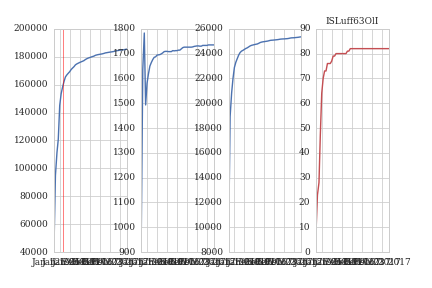

2017-01-08 00:07:01
2017-02-28 01:01:32
Age: 51
First 6 days made 0.773819690992 %


/home/mlode/intel/intelpython27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [8]:
# video sample statistics

from sklearn import preprocessing

name = 'ISLuff63OlI'
group = video_groups.get_group(name)

print name
fig, axs = plt.subplots(ncols=4)
plt.title(name)
axs[0].plot_date(group['crawlTimestamp'], group['viewCount'], 'b-')
axs[0].axvline(group.iloc[0, 5] + timedelta(days=6), color='red', linewidth=.5)
axs[1].plot_date(group['crawlTimestamp'], group['commentCount'], 'b-')
axs[2].plot_date(group['crawlTimestamp'], group['likeCount'], 'b-')
axs[3].plot_date(group['crawlTimestamp'], group['dislikeCount'], 'r-')

    
print group['crawlTimestamp'].min()
print group['crawlTimestamp'].max()
print 'Age:', (group['crawlTimestamp'].max() - group['crawlTimestamp'].min()).days

# views percentage
# Create x, where x the scores columns values as floats
x = group['viewCount'].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
group['viewCount_norm'] = x_scaled

print 'First 6 days made', group[(group.crawlTimestamp <= group.iloc[0, 5] + timedelta(days=6))]['viewCount_norm'].max(), '%'

#group

IL_dFzAuGDw


<IPython.core.display.Javascript object>


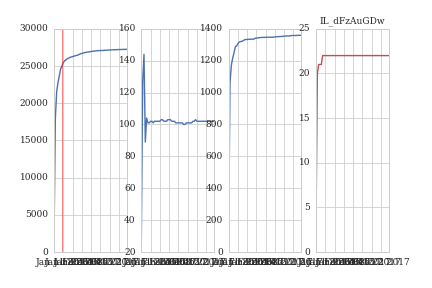

AlXRPpMSeUg


<IPython.core.display.Javascript object>


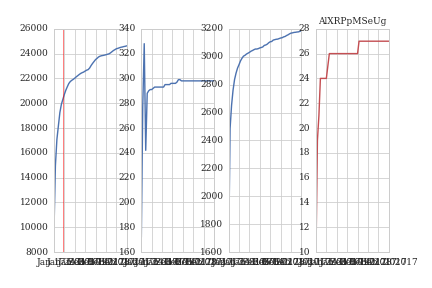

gVLby7G7grg


<IPython.core.display.Javascript object>


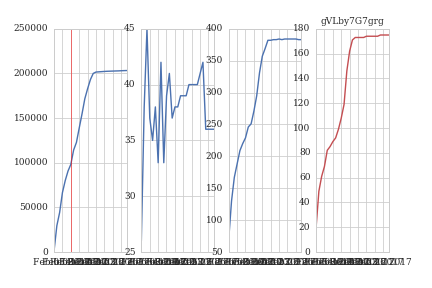

EFriEz8FVjc


<IPython.core.display.Javascript object>


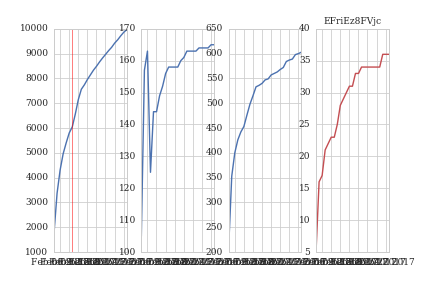

PEc_BTWAXew


<IPython.core.display.Javascript object>


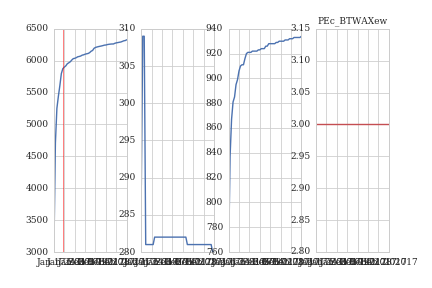

44SFvGAy7Ls


<IPython.core.display.Javascript object>


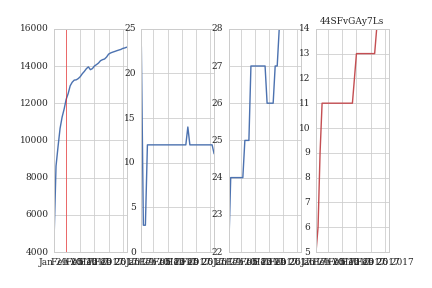

M1IUjWJ4cOs


<IPython.core.display.Javascript object>


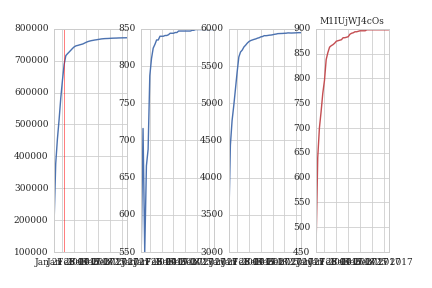

n0TBv3MMZ7c


<IPython.core.display.Javascript object>


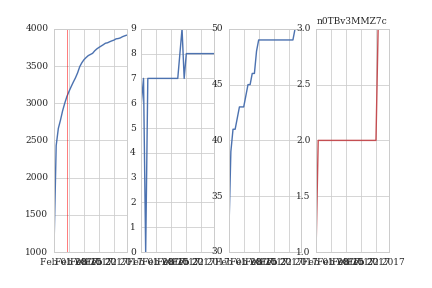

o3YEGsGMNGs


<IPython.core.display.Javascript object>


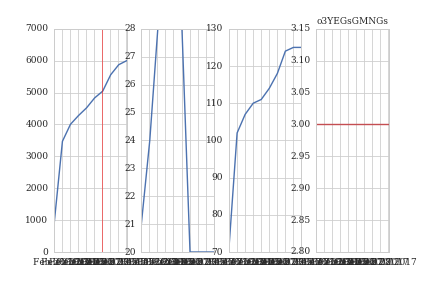

vcm3jW5TWMk


<IPython.core.display.Javascript object>


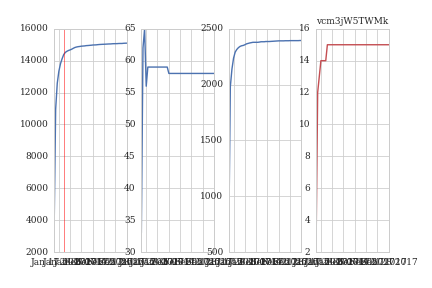

In [9]:
# multi sample channel statistics
import random


sampled_df_i  = random.sample(video_groups.indices, 10)
df_list  = map(lambda df_i: (df_i, video_groups.get_group(df_i)), sampled_df_i)


for name, group in df_list:
    print name
    fig, axs = plt.subplots(ncols=4)
    plt.title(name)
    axs[0].plot_date(group['crawlTimestamp'], group['viewCount'], 'b-')
    axs[0].axvline(group.iloc[0, 5] + timedelta(days=6), color='red', linewidth=.5)
    axs[1].plot_date(group['crawlTimestamp'], group['commentCount'], 'b-')
    axs[2].plot_date(group['crawlTimestamp'], group['likeCount'], 'b-')
    axs[3].plot_date(group['crawlTimestamp'], group['dislikeCount'], 'r-')


In [12]:
# difference between video stats of collab and non_collab videos of same channel
# are collab videos more popular than normal for channel?


In [13]:
# create boxplot per channel, collab noncollab videos compared
# comparing what?
# viewcount gradient?
# viewcount max, mean? -> max mean of collab, non_collab videos
# consider age of video? take only first 6 days into account

In [14]:
# age dist, for all videos

df_video_age = []

for name, group in video_groups:

    age = (group['crawlTimestamp'].max() - group['crawlTimestamp'].min()).days
    df_video_age.append((name, age))
    
df_video_age = pa.DataFrame(df_video_age, columns=['id', 'age'])

KeyboardInterrupt: 

0


<IPython.core.display.Javascript object>


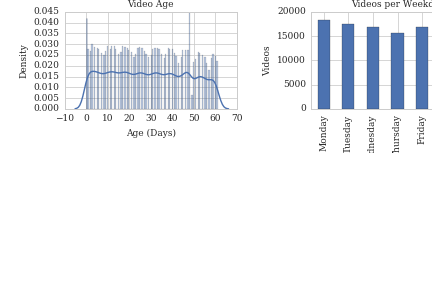

,id,age,date,dayn
0,--0s03JYIww,27,2017-01-24,Tuesday
1,--1lgNZ9cvY,14,2017-01-11,Wednesday
2,--4kDK_RBjg,48,2017-02-14,Tuesday
3,--4n0eZ8XTQ,1,2016-12-29,Thursday
4,--5mUkeFBmI,56,2017-02-22,Wednesday


In [118]:

df_video_age['date'] = df_video_age['age'].apply(lambda x: date(2016, 12, 28) + timedelta(days=x))
df_video_age['dayn'] = df_video_age['date'].apply(lambda x: x.strftime("%A"))

print df_video_age['age'].min()

#ax = df_video_age[['date']].groupby(df_video_age['date']).count().plot(kind='bar')
test = df_video_age[['dayn']].groupby(df_video_age['dayn']).count()
order = [u'Monday',u'Tuesday',u'Wednesday',u'Thursday',u'Friday',u'Saturday',u'Sunday']


fig, axs = plt.subplots(1, 2)

#fig, ax = plt.subplots()
ax = test.ix[order].plot(kind='bar',legend=False, ax=axs[1])
ax.set_xlabel('Weekday')
ax.set_ylabel('Videos')
fig.tight_layout()
axs[1].set_title('Videos per Weekday')
#save_plot('video_weekday_counts.pdf', fig, s_width, s_height)

#ax.set_xticks(ax.get_xticks()[::2])
#fig = plt.figure()
ax = sns.distplot(df_video_age['age'], bins=100, ax=axs[0])
ax.set_xlabel('Age (Days)')
ax.set_ylabel('Density')
fig.tight_layout()
axs[0].set_title('Video Age')

save_plot('video_age_and_days.pdf', fig, 2*s_width, s_height)
#ax.set_xticklabels(df_video_age['date'])
#age_groups = range(0, 70, 5)
#print age_groups
#for age in age_groups:
#    ax.axvline(age, color='red', linewidth=.5)



df_video_age.head()

In [10]:
# get all videos
with db._session_scope(False) as session:

    df_videos = pa.read_sql(session.query(Video).statement, db.engine)
    

df_videos = df_videos.set_index(['id'])

df_videos['dateAdded'] = df_videos['dateAdded'].apply(lambda x: datetime.strptime(x, date_format))
df_videos['crawlTimestamp'] = df_videos['crawlTimestamp'].apply(lambda x: datetime.strptime(x, date_format2))


# filter videos only related to channel whith collabs

df_videos_collabs = df_videos[ (df_videos.channelID.isin(df_graph_filtered['from'].tolist())) | (df_videos.channelID.isin(df_graph_filtered['to'].tolist()))]

#df_videos_collabs.head()

print 'All videos:', len(df_videos)
print 'Collab related videos:', len(df_videos_collabs)

df_videos_collabs.head()

All videos: 122447
Collab related videos: 29284


,channelID,title,description,category,dateAdded,tags,topicIds,attribution,duration,crawlTimestamp,deleted
id,,,,,,,,,,,
__a6tnmzoU4,UCxL7KXCV5YW0KdPRV583VJQ,NEW YEAR NEW BABY!?,WHATS IN MY BAG? → http://bit.ly/2iO7QLz\nWATC...,22,2017-01-13 20:00:30,"[""new year"",""new years"",""baby"",""pregnant"",""new...",[],None,PT7M32S,2017-01-14 00:13:27,None
__C71keq5BA,UCkQO3QsgTpNTsOw6ujimT5Q,10 Famous People Who Aren't What You Think The...,Often the image of famous people can outrun th...,24,2017-02-18 14:10:01,"[""famous people"",""celebrities"",""mindblowing"",""...",[],None,PT11M33S,2017-02-19 00:12:33,None
__fG-cIQjQU,UCum7cqUcF_q6PjE8LW5V2Gw,DUBSTEP SUCKS???,DUBSTEP SUCKS (i like dubstep. the title is ju...,24,2017-01-04 16:00:04,"[""GUTTER"",""DUBSTEP SUCKS"",""dubstep"",""dubstep 2...","[""/m/07s72n""]",None,PT5M27S,2017-01-05 00:10:59,None
__omrNcN9io,UCZUrS0zDszsXI_5ir_tI3cg,А ТЫ СМОЖЕШЬ ПРОЙТИ ЭТУ ИГРУ?,А ТЫ СМОЖЕШЬ ПРОЙТИ ЭТУ ИГРУ?\n============Заг...,24,2017-02-18 12:57:23,"[""windy31"",""\u0432\u0438\u043d\u0434\u0438"",""\...",[],None,PT10M13S,2017-02-19 00:16:19,None
_-fm4Bbul2k,UCV50BP4xUIQ-Zj61xRl0BIA,SSJ White Gohan Coming To Super - REAL or FAKE?,I've been told a rare Super Saiyan White Gohan...,1,2017-02-19 19:10:26,"[""Super Saiyan White"",""SSJ White Gohan"",""Super...","[""/m/01k32j""]",None,PT2M51S,2017-02-20 00:15:26,None


In [11]:
with db._session_scope(False) as session:

    df_channel_history_collabs = pa.read_sql(session.query(ChannelHistory).filter((ChannelHistory.channelID.in_(df_graph_filtered['from'].tolist())) | (ChannelHistory.channelID.in_(df_graph_filtered['to'].tolist()))).statement, db.engine)

channel_collabs_groups = df_channel_history_collabs.groupby(['channelID'])

print len(df_channel_history_collabs), len(channel_collabs_groups)

67776 1059


In [12]:
print len(df_graph_filtered)

df_collab_channels = pa.Series([])

df_collab_channels = df_collab_channels.append(df_graph_filtered['to'])
df_collab_channels = df_collab_channels.append(df_graph_filtered['from'])

print len(df_collab_channels.unique())
df_collab_channels.head()

1214
1059


0    UC5evWLowv059QIovMFlKKBA
1    UC4WjlJxCPSbykB0P3R1My1Q
2    UC7IJcslj7NPvo12tyO5Qguw
3    UCY26xU0-avwTJ6F6TzUZVEw
4    UC7Rrbm84x8RK0OkKlHpmiUQ
dtype: object

In [13]:
# mark videos collab or non_collab
# create video collab list


df_videos_collabs['collab_window'] = 'Non_Collab'

for name, group in channel_collabs_groups:
    videos = []
    # own videos
    for index, row in df_graph_filtered[df_graph_filtered['to'] == name].iterrows():
        #print row.videos
        for vid in row['videos']:
            df_videos_collabs.ix[vid, 'collab_window'] = 'Collab'

    # external videos (hes in)
    for index, row in df_graph_filtered[df_graph_filtered['from'] == name].iterrows():
        #print row.videos
        for vid in row['videos']:
            df_videos_collabs.ix[vid, 'collab_window'] = 'Collab'
            
print len(df_videos_collabs)
df_videos_collabs.head()

/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


29348


,channelID,title,description,category,dateAdded,tags,topicIds,attribution,duration,crawlTimestamp,deleted,collab_window
id,,,,,,,,,,,,
__a6tnmzoU4,UCxL7KXCV5YW0KdPRV583VJQ,NEW YEAR NEW BABY!?,WHATS IN MY BAG? → http://bit.ly/2iO7QLz\nWATC...,22.0,2017-01-13 20:00:30,"[""new year"",""new years"",""baby"",""pregnant"",""new...",[],None,PT7M32S,2017-01-14 00:13:27,None,Collab
__C71keq5BA,UCkQO3QsgTpNTsOw6ujimT5Q,10 Famous People Who Aren't What You Think The...,Often the image of famous people can outrun th...,24.0,2017-02-18 14:10:01,"[""famous people"",""celebrities"",""mindblowing"",""...",[],None,PT11M33S,2017-02-19 00:12:33,None,Non_Collab
__fG-cIQjQU,UCum7cqUcF_q6PjE8LW5V2Gw,DUBSTEP SUCKS???,DUBSTEP SUCKS (i like dubstep. the title is ju...,24.0,2017-01-04 16:00:04,"[""GUTTER"",""DUBSTEP SUCKS"",""dubstep"",""dubstep 2...","[""/m/07s72n""]",None,PT5M27S,2017-01-05 00:10:59,None,Non_Collab
__omrNcN9io,UCZUrS0zDszsXI_5ir_tI3cg,А ТЫ СМОЖЕШЬ ПРОЙТИ ЭТУ ИГРУ?,А ТЫ СМОЖЕШЬ ПРОЙТИ ЭТУ ИГРУ?\n============Заг...,24.0,2017-02-18 12:57:23,"[""windy31"",""\u0432\u0438\u043d\u0434\u0438"",""\...",[],None,PT10M13S,2017-02-19 00:16:19,None,Non_Collab
_-fm4Bbul2k,UCV50BP4xUIQ-Zj61xRl0BIA,SSJ White Gohan Coming To Super - REAL or FAKE?,I've been told a rare Super Saiyan White Gohan...,1.0,2017-02-19 19:10:26,"[""Super Saiyan White"",""SSJ White Gohan"",""Super...","[""/m/01k32j""]",None,PT2M51S,2017-02-20 00:15:26,None,Non_Collab


In [14]:
print len(df_videos_collabs)

print len(df_videos_collabs[df_videos_collabs.collab_window=='Collab'])

print len(df_videos_collabs[df_videos_collabs.collab_window=='Non_Collab'])


29348
1682
27666


In [15]:
# calculate video view gradient like for channel, see if difference for collabs

#video_groups_filtered = df_video_history_filtered

print len(video_groups_filtered)
print len(df_videos_collabs)
mask = df_videos_collabs.index

df_video_history_collabs = df_video_history_filtered[df_video_history_filtered.videoID.isin(mask)]
video_history_collab_group = df_video_history_collabs.groupby('videoID')
print len(video_history_collab_group)

name = 'ISLuff63OlI'
group = video_groups_filtered.get_group(name)
group


98688
29348
23752


,videoID,viewCount,commentCount,likeCount,dislikeCount,crawlTimestamp
id,,,,,,
104359,ISLuff63OlI,43757,998,9311,8,2017-01-08 00:07:01
130577,ISLuff63OlI,95042,1636,18926,23,2017-01-09 00:18:36
154057,ISLuff63OlI,111248,1783,20836,28,2017-01-10 01:57:43
177787,ISLuff63OlI,120890,1493,21973,47,2017-01-11 00:18:11
203661,ISLuff63OlI,145063,1581,22880,64,2017-01-12 00:18:48
231447,ISLuff63OlI,153391,1619,23301,70,2017-01-13 00:19:22
261325,ISLuff63OlI,158178,1650,23594,73,2017-01-14 00:19:44
292989,ISLuff63OlI,162127,1664,23883,73,2017-01-15 00:19:26
326392,ISLuff63OlI,165471,1676,24084,76,2017-01-16 00:21:15


In [16]:
# fix zero entries

for name, group in video_history_collab_group:
    if 0 in group['viewCount'].values:
        print name
        subs = group['viewCount'].values.astype(float)
        subs[subs==0] = 1.0
        print subs
        df_video_history_collabs.ix[group.index, 'viewCount'] = subs

0o1Hn80NydU
[  1.  17.  26.  29.  31.  36.  39.  41.  44.  44.  45.  45.  45.  47.  47.
  47.  48.  48.  49.  49.  49.  49.  51.  51.  52.  54.]


/home/mlode/intel/intelpython27/lib/python2.7/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


4cY-j4Cr_Ek
[  1.00000000e+00   1.64910000e+04   1.84540000e+04   1.88660000e+04
   1.93310000e+04   1.95850000e+04   1.97490000e+04   1.98280000e+04
   1.98870000e+04   1.99340000e+04   1.99710000e+04   2.00080000e+04
   2.00450000e+04   2.00890000e+04   2.01240000e+04   2.01450000e+04
   2.01720000e+04   2.01960000e+04   2.02170000e+04   2.02360000e+04
   2.02530000e+04   2.02630000e+04   2.02790000e+04   2.02850000e+04
   2.02930000e+04   2.03010000e+04   2.03100000e+04   2.03160000e+04
   2.03200000e+04   2.03250000e+04   2.03310000e+04   2.03370000e+04
   2.03440000e+04   2.03480000e+04   2.03520000e+04   2.03650000e+04
   2.03690000e+04   2.03710000e+04   2.03750000e+04   2.03810000e+04
   2.03850000e+04   2.03930000e+04]
BdLzQFiTmoM
[ 1.  2.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
Bp1vLvSkbEU
[  1.   1.   1.   1.   1.   3.   3.   3.   7. 

In [ ]:
# label every video history point either collab or non_collab
# calc gradient and p_gradient of viewcounts
# compare gradients then

df_video_history_collabs['gradient'] = np.nan
df_video_history_collabs['p_gradient'] = np.nan
df_video_history_collabs['collab_window'] = 'Non_Collab'

cnt=0

for name, group in video_history_collab_group:
    
    if len(group['viewCount']) < 2:
        cnt += 1
        continue
    
    subs = group['viewCount'].values
    group.drop(group.index[:1], inplace=True)
    df_video_history_collabs.ix[group.index, 'gradient'] = np.diff(subs)
    df_video_history_collabs.ix[group.index, 'p_gradient'] = [100.0 * a1 / a2 - 100 for a1, a2 in zip(subs[1:], subs)]

    # set collab or non collab
    df_video_history_collabs.ix[group.index, 'collab_window'] = df_videos_collabs.ix[name, 'collab_window']


print cnt

print 'Non_Collabs:'
print df_video_history_collabs[df_video_history_collabs.collab_window=='Non_Collab']['gradient'].describe()
print '\nCollabs:'
print df_video_history_collabs[df_video_history_collabs.collab_window=='Collab']['gradient'].describe()

print '\nNon_Collabs:'
print df_video_history_collabs[df_video_history_collabs.collab_window=='Non_Collab']['p_gradient'].describe()
print '\nCollabs:'
print df_video_history_collabs[df_video_history_collabs.collab_window=='Collab']['p_gradient'].describe()


/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

In [149]:
print 'Non_Collabs:'
print df_video_history_collabs[df_video_history_collabs.collab_window=='Non_Collab']['gradient'].describe()
print '\nCollabs:'
print df_video_history_collabs[df_video_history_collabs.collab_window=='Collab']['gradient'].describe()

print '\nNon_Collabs:'
print df_video_history_collabs[df_video_history_collabs.collab_window=='Non_Collab']['p_gradient'].describe()
print '\nCollabs:'
print df_video_history_collabs[df_video_history_collabs.collab_window=='Collab']['p_gradient'].describe()


Non_Collabs:
count    7.706600e+05
mean     5.624810e+03
std      4.238114e+04
min     -4.762700e+04
25%      3.200000e+01
50%      2.400000e+02
75%      1.681000e+03
max      7.837219e+06
Name: gradient, dtype: float64

Collabs:
count    6.986200e+04
mean     8.113632e+03
std      5.144452e+04
min     -6.311000e+03
25%      6.200000e+01
50%      4.830000e+02
75%      3.064000e+03
max      4.143230e+06
Name: gradient, dtype: float64

Non_Collabs:
count    7.706600e+05
mean     1.513317e+02
std      7.207172e+04
min     -5.760870e+01
25%      2.257485e-01
50%      6.688963e-01
75%      2.159801e+00
max      5.090080e+07
Name: p_gradient, dtype: float64

Collabs:
count    69862.000000
mean        16.671923
std        275.102239
min        -83.098592
25%          0.271631
50%          0.712907
75%          2.164279
max      28574.134199
Name: p_gradient, dtype: float64
11
271


,videoID,viewCount,commentCount,likeCount,dislikeCount,crawlTimestamp,gradient,p_gradient,collab_window
id,,,,,,,,,
8187,QxkLOmnPgWw,318291.0,211,816,190,2016-12-31 00:12:30,318124.0,1.904934e+05,Non_Collab
165438,pTde-GqmA0Q,509009.0,7147,11780,356,2017-01-10 02:08:32,509008.0,5.090080e+07,Non_Collab
302934,YSKIeFEzDBg,51443.0,618,2871,22,2017-01-15 00:28:35,51442.0,5.144200e+06,Non_Collab
458512,4cY-j4Cr_Ek,16491.0,225,453,106,2017-01-19 00:43:04,16490.0,1.649000e+06,Non_Collab
883685,CZABmZw7g2M,22210.0,1015,4409,29,2017-01-28 00:29:59,22209.0,2.220900e+06,Non_Collab
1267367,cxrnm2L43Js,40685.0,694,2058,95,2017-02-03 00:36:45,40679.0,6.779833e+05,Non_Collab
1937573,VeFpdDQNmzw,3967.0,159,448,9,2017-02-11 01:24:35,3966.0,3.966000e+05,Non_Collab
2194991,r2sRijN8dVE,370925.0,5969,46191,842,2017-02-14 01:15:36,370924.0,3.709240e+07,Non_Collab
2242024,aUXs-O0JYPQ,307990.0,5287,70432,1475,2017-02-15 00:34:46,307917.0,4.218041e+05,Non_Collab


In [150]:
print len(df_video_history_collabs)

print len(df_video_history_collabs[df_video_history_collabs.gradient.notnull()])

df_video_history_collabs.to_csv(DIR+r'/df_video_history_collabs.txt', sep=str('\t'), encoding='utf-8')

864274
840522


In [162]:
df_video_history_collabs_test = df_video_history_collabs[df_video_history_collabs.p_gradient<10000]

<IPython.core.display.Javascript object>


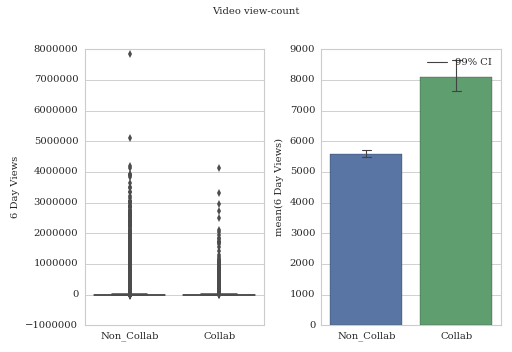

<IPython.core.display.Javascript object>


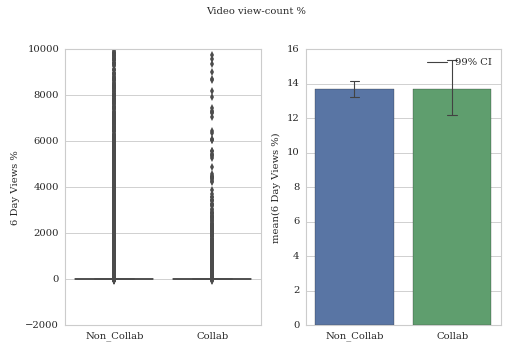

In [226]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.boxplot(x="collab_window", y="gradient", data=df_video_history_collabs_test, ax=ax1)
sns.barplot(x="collab_window", y="gradient", data=df_video_history_collabs_test, ci=99,errwidth=1., capsize=.1, ax=ax2)
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Views')
ax2.set_ylabel('mean(Views)')
fig.suptitle('Video view-count')
fig.tight_layout()
fig.subplots_adjust(top=0.86)

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.boxplot(x="collab_window", y="p_gradient", data=df_video_history_collabs_test, ax=ax1)
sns.barplot(x="collab_window", y="p_gradient", data=df_video_history_collabs_test, ci=99,errwidth=1., capsize=.1, ax=ax2)
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Views %')
ax2.set_ylabel('mean(Views %)')
fig.suptitle('Video view-count %')
fig.tight_layout()
fig.subplots_adjust(top=0.86)

<IPython.core.display.Javascript object>


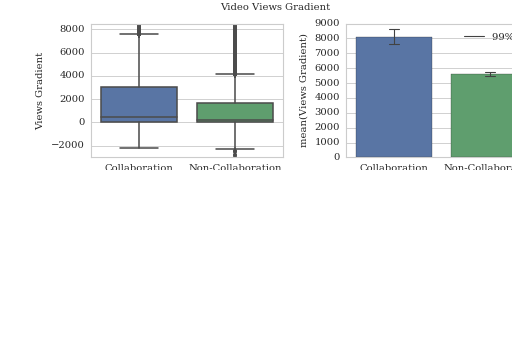

<IPython.core.display.Javascript object>


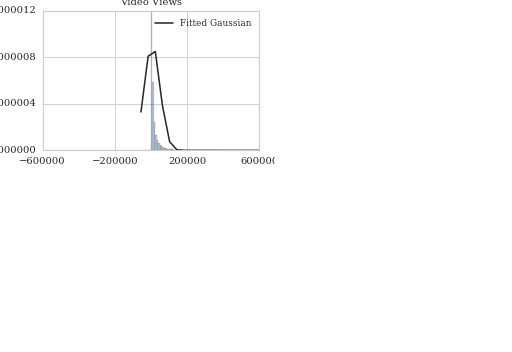

Normal-dist-test: NormaltestResult(statistic=2530243.9240702055, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=30236141299.0, pvalue=0.0) 
p*2: 0.0
Wilcoxon rank-sum-test: RanksumsResult(statistic=54.265554042771072, pvalue=0.0) 
p*2: 0.0


In [227]:
# Boxplot viewcount gradient for collab videos 

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.boxplot(x="collab_window", y="gradient", data=df_video_history_collabs_test, ax=ax1, order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="gradient", data=df_video_history_collabs_test, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Views Gradient')
ax2.set_ylabel('mean(Views Gradient)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Video Views Gradient')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-3000.0, 8500.0])
save_plot('collab_video_views_box_ci.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_video_history_collabs_test[df_video_history_collabs_test["gradient"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['gradient'])

fig = plt.figure()
ax = sns.distplot(test['gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["$\mu=${0:.2g}, $\sigma=${1:.2f}".format(mu, sigma)])
#plt.legend(["Fitted normal dist"])
ax.set_xlabel('Views')
ax.set_ylabel('Density')
plt.title('Video Views')
ax.set_ylim([0.0, 1.1e-05])
ax.set_xlim([-550000.0, 550000.0])
ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
plt.tight_layout()
plt.legend(["Fitted Gaussian"],prop={'size':8})
save_plot('collab_video_views_norm_fit.pdf', fig, s_width, s_height)
print 'Normal-dist-test:', normaltest(test['gradient'])

collabs_grads = test[test.collab_window == 'Collab']['gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2


<IPython.core.display.Javascript object>


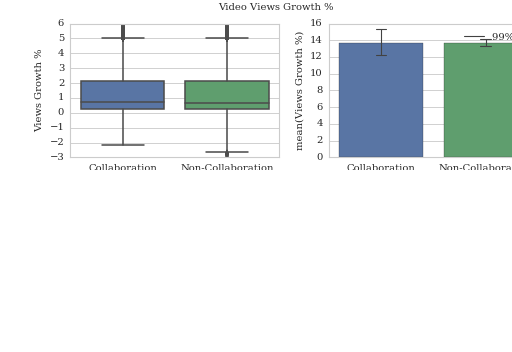

<IPython.core.display.Javascript object>


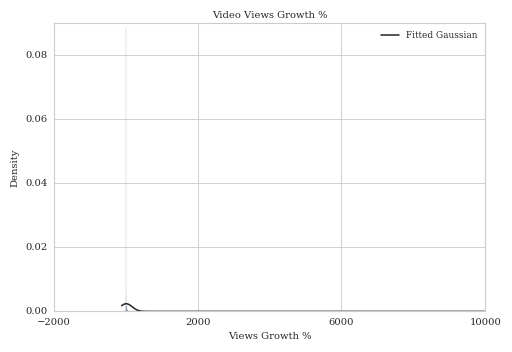

Normal-dist-test: NormaltestResult(statistic=2237357.8447952336, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=27765650417.5, pvalue=1.1968068987874011e-44) 
p*2: 2.39361379757e-44
Wilcoxon rank-sum-test: RanksumsResult(statistic=14.018277490930842, pvalue=1.2050405816295072e-44) 
p*2: 2.41008116326e-44
count    69847.000000
mean        13.701337
std        172.208913
min        -83.098592
25%          0.271553
50%          0.712703
75%          2.162580
max       9766.253102
Name: p_gradient, dtype: float64
count    770403.000000
mean         13.716420
std         164.213366
min         -57.608696
25%           0.225671
50%           0.668484
75%           2.156231
max        9961.585366
Name: p_gradient, dtype: float64
0.712702916788
0.668483904465


In [256]:
# Boxplot view count percental gradient for collab videos 

fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.boxplot(x="collab_window", y="p_gradient", data=df_video_history_collabs_test, ax=ax1, order=['Collab', 'Non_Collab'])
sns.barplot(x="collab_window", y="p_gradient", data=df_video_history_collabs_test, ci=99, errwidth=1., capsize=.1, ax=ax2, order=['Collab', 'Non_Collab'])
plt.legend(["{}% CI".format(99)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Views Growth %')
ax2.set_ylabel('mean(Views Growth %)')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.suptitle('Video Views Growth %')
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-3.0, 6.0])
save_plot('collab_video_views_box_ci_perc.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_video_history_collabs_test[df_video_history_collabs_test["p_gradient"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['p_gradient'])

fig = plt.figure()
ax = sns.distplot(test['p_gradient'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["$\mu=${0:.2g}, $\sigma=${1:.2f}".format(mu, sigma)])
#plt.legend(["Fitted normal dist"])
ax.set_xlabel('Views Growth %')
ax.set_ylabel('Density')
plt.title('Video Views Growth %')
#ax.set_ylim([0.0, 1.1e-05])
#ax.set_xlim([-550000.0, 550000.0])
ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
plt.tight_layout()
plt.legend(["Fitted Gaussian"],prop={'size':8})
#save_plot('collab_video_views_norm_fit.pdf', fig, s_width, s_height)
print 'Normal-dist-test:', normaltest(test['p_gradient'])

collabs_grads = test[test.collab_window == 'Collab']['p_gradient']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['p_gradient']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2

print test[test.collab_window == 'Collab']['p_gradient'].describe()
print test[test.collab_window == 'Non_Collab']['p_gradient'].describe()

print test[test.collab_window == 'Collab']['p_gradient'].median()
print test[test.collab_window == 'Non_Collab']['p_gradient'].median()

In [183]:
# get for all videos in df_videos_collabs the max popaurlty statiscs vlaue of the 12 days data

df_videos_collabs['12day_viewmax'] = np.nan
df_videos_collabs['12day_likemax'] = np.nan
df_videos_collabs['12day_dislikemax'] = np.nan
df_videos_collabs['12day_commentmax'] = np.nan

for index, group in video_history_collab_group:

    df_videos_collabs.ix[index, '12day_viewmax'] = group['viewCount'].max()
    df_videos_collabs.ix[index, '12day_likemax'] = group['likeCount'].max()
    df_videos_collabs.ix[index, '12day_dislikemax'] = group['dislikeCount'].max()
    df_videos_collabs.ix[index, '12day_commentmax'] = group['commentCount'].max()

In [191]:
print len(df_videos_collabs)
print df_videos_collabs['12day_viewmax'].describe()
print len(df_videos_collabs[df_videos_collabs['12day_viewmax'].isnull()])
print df_videos_collabs['12day_likemax'].describe()
print len(df_videos_collabs[df_videos_collabs['12day_likemax'].isnull()])
print df_videos_collabs['12day_dislikemax'].describe()
print len(df_videos_collabs[df_videos_collabs['12day_dislikemax'].isnull()])
print df_videos_collabs['12day_commentmax'].describe()
print len(df_videos_collabs[df_videos_collabs['12day_commentmax'].isnull()])

29284
count    2.375200e+04
mean     2.444371e+05
std      6.959356e+05
min      1.000000e+00
25%      7.128750e+03
50%      4.166950e+04
75%      1.895190e+05
max      3.136236e+07
Name: 12day_viewmax, dtype: float64
5532
count    2.375200e+04
mean     1.120149e+04
std      4.334455e+04
min      0.000000e+00
25%      2.050000e+02
50%      1.300500e+03
75%      6.439250e+03
max      1.956001e+06
Name: 12day_likemax, dtype: float64
5532
count     23752.000000
mean        374.898703
std        3195.250268
min           0.000000
25%           7.000000
50%          39.000000
75%         188.000000
max      402205.000000
Name: 12day_dislikemax, dtype: float64
5532
count    2.375200e+04
mean     1.580447e+03
std      3.576909e+04
min      0.000000e+00
25%      4.400000e+01
50%      2.090000e+02
75%      8.412500e+02
max      5.443731e+06
Name: 12day_commentmax, dtype: float64
5532


In [192]:
# save to file
df_videos_collabs.to_csv(DIR+r'/df_video_collabs_stats.txt', sep=str('\t'), encoding='utf-8')
#df_videos_collabs = pa.read_csv(DIR+r'/df_video_collabs_stats.txt', sep=str('\t'), encoding='utf-8')
#df_videos_collabs=df_videos_collabs.set_index(['id'])
df_videos_collabs.head()

,channelID,title,description,category,dateAdded,tags,topicIds,attribution,duration,crawlTimestamp,deleted,collab_window,6day_viewmax,6day_likemax,6day_dislikemax,6day_commentmax,12day_viewmax,12day_likemax,12day_dislikemax,12day_commentmax
id,,,,,,,,,,,,,,,,,,,,
__a6tnmzoU4,UCxL7KXCV5YW0KdPRV583VJQ,NEW YEAR NEW BABY!?,WHATS IN MY BAG? → http://bit.ly/2iO7QLz\nWATC...,22,2017-01-13 20:00:30,"[""new year"",""new years"",""baby"",""pregnant"",""new...",[],NaN,PT7M32S,2017-01-14 00:13:27,NaN,Collab,418033.0,10111.0,362.0,1137.0,516683.0,11471.0,400.0,1358.0
__C71keq5BA,UCkQO3QsgTpNTsOw6ujimT5Q,10 Famous People Who Aren't What You Think The...,Often the image of famous people can outrun th...,24,2017-02-18 14:10:01,"[""famous people"",""celebrities"",""mindblowing"",""...",[],NaN,PT11M33S,2017-02-19 00:12:33,NaN,Non_Collab,237873.0,3801.0,800.0,1252.0,NaN,NaN,NaN,NaN
__fG-cIQjQU,UCum7cqUcF_q6PjE8LW5V2Gw,DUBSTEP SUCKS???,DUBSTEP SUCKS (i like dubstep. the title is ju...,24,2017-01-04 16:00:04,"[""GUTTER"",""DUBSTEP SUCKS"",""dubstep"",""dubstep 2...","[""/m/07s72n""]",NaN,PT5M27S,2017-01-05 00:10:59,NaN,Non_Collab,17740.0,3491.0,55.0,670.0,24915.0,3866.0,63.0,945.0
__omrNcN9io,UCZUrS0zDszsXI_5ir_tI3cg,А ТЫ СМОЖЕШЬ ПРОЙТИ ЭТУ ИГРУ?,А ТЫ СМОЖЕШЬ ПРОЙТИ ЭТУ ИГРУ?\n============Заг...,24,2017-02-18 12:57:23,"[""windy31"",""\u0432\u0438\u043d\u0434\u0438"",""\...",[],NaN,PT10M13S,2017-02-19 00:16:19,NaN,Non_Collab,229515.0,10902.0,232.0,1426.0,NaN,NaN,NaN,NaN
_-fm4Bbul2k,UCV50BP4xUIQ-Zj61xRl0BIA,SSJ White Gohan Coming To Super - REAL or FAKE?,I've been told a rare Super Saiyan White Gohan...,1,2017-02-19 19:10:26,"[""Super Saiyan White"",""SSJ White Gohan"",""Super...","[""/m/01k32j""]",NaN,PT2M51S,2017-02-20 00:15:26,NaN,Non_Collab,18243.0,768.0,24.0,202.0,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>


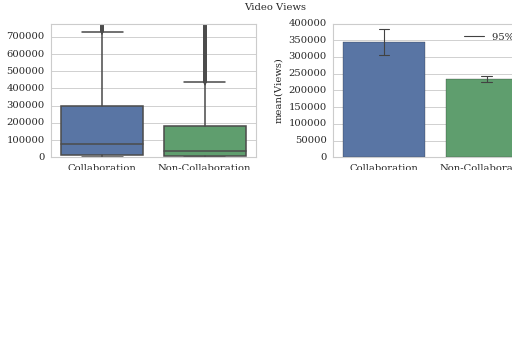

<IPython.core.display.Javascript object>


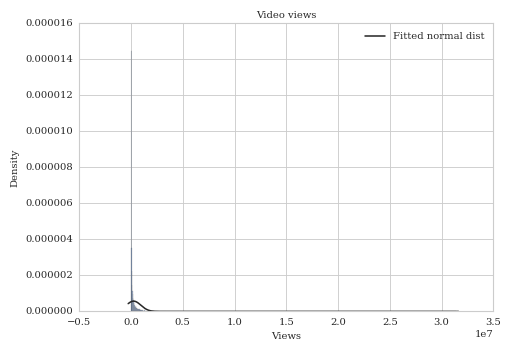

Normal-dist-test: NormaltestResult(statistic=40300.280941114892, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=24762045.5, pvalue=5.3014584447949675e-26) 
p*2: 1.06029168896e-25
Wilcoxon rank-sum-test: RanksumsResult(statistic=10.545986353158989, pvalue=5.3013629772184523e-26) 
p*2: 1.06027259544e-25


<IPython.core.display.Javascript object>


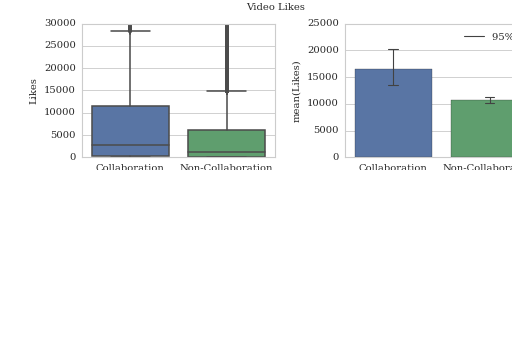

<IPython.core.display.Javascript object>


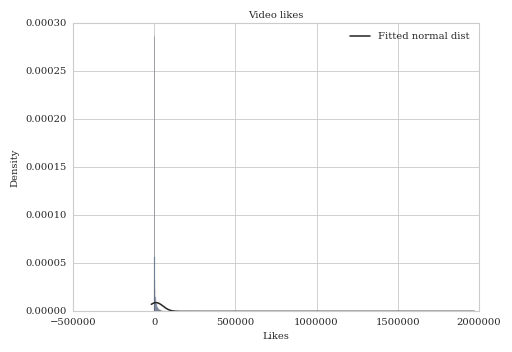

Normal-dist-test: NormaltestResult(statistic=45984.408857337003, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=25261353.0, pvalue=1.6669415219054264e-34) 
p*2: 3.33388304381e-34
Wilcoxon rank-sum-test: RanksumsResult(statistic=12.250597663214968, pvalue=1.6676239083365584e-34) 
p*2: 3.33524781667e-34


<IPython.core.display.Javascript object>


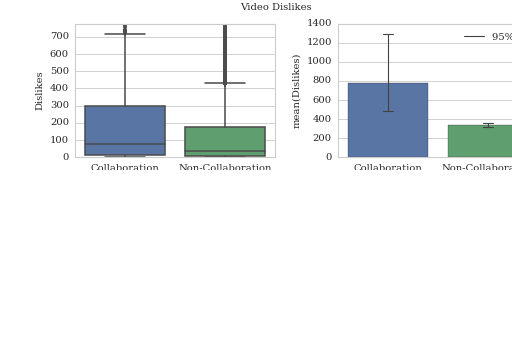

<IPython.core.display.Javascript object>


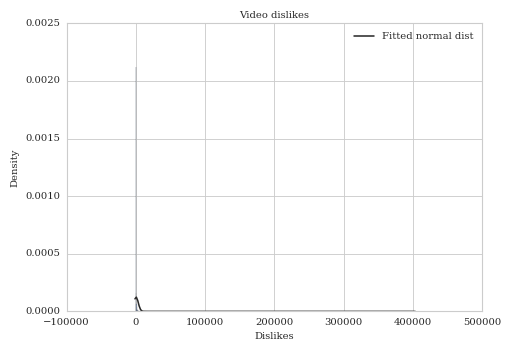

Normal-dist-test: NormaltestResult(statistic=90770.85755031454, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=25355563.5, pvalue=2.8860842326428653e-36) 
p*2: 5.77216846529e-36
Wilcoxon rank-sum-test: RanksumsResult(statistic=12.57222768845198, pvalue=3.0014564162054946e-36) 
p*2: 6.00291283241e-36


<IPython.core.display.Javascript object>


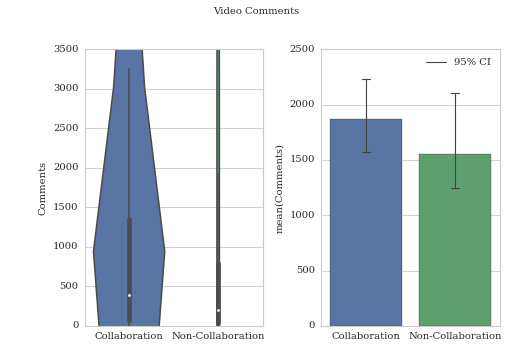

<IPython.core.display.Javascript object>


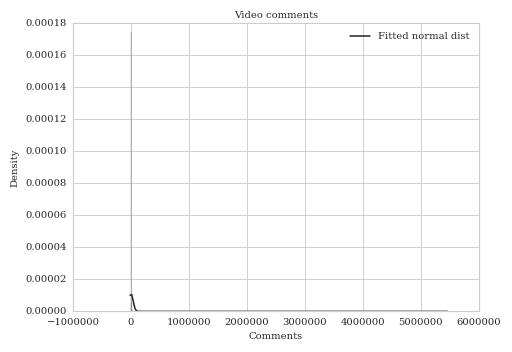

Normal-dist-test: NormaltestResult(statistic=106535.86292048429, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=25091201.0, pvalue=1.8182359867786448e-31) 
p*2: 3.63647197356e-31
Wilcoxon rank-sum-test: RanksumsResult(statistic=11.669707082503393, pvalue=1.8204897127997066e-31) 
p*2: 3.6409794256e-31


In [252]:
# all viewcounts complete
# for all channel mixed not very good/accurate, as channel have different popularities

from scipy.stats import norm, normaltest, mannwhitneyu, ranksums


fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.boxplot(x="collab_window", y="12day_viewmax", data=df_videos_collabs, ax=ax1)
sns.barplot(x="collab_window", y="12day_viewmax", data=df_videos_collabs, ci=95,errwidth=1., capsize=.1, ax=ax2)
plt.legend(["{}% CI".format(95)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Views')
ax2.set_ylabel('mean(Views)')
fig.suptitle('Video Views')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([0.0, 777000.0])
save_plot('collab_video_12day_view_box_ci.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_videos_collabs[df_videos_collabs["12day_viewmax"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['12day_viewmax'])

fig = plt.figure()
ax = sns.distplot(test['12day_viewmax'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Views')
ax.set_ylabel('Density')
plt.title('Video views')
plt.tight_layout()

print 'Normal-dist-test:', normaltest(test['12day_viewmax'])

collabs_grads = test[test.collab_window == 'Collab']['12day_viewmax']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['12day_viewmax']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2


fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.boxplot(x="collab_window", y="12day_likemax", data=df_videos_collabs, ax=ax1)
sns.barplot(x="collab_window", y="12day_likemax", data=df_videos_collabs, ci=95,errwidth=1., capsize=.1, ax=ax2)
plt.legend(["{}% CI".format(95)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Likes')
ax2.set_ylabel('mean(Likes)')
fig.suptitle('Video Likes')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([0.0, 30000.0])
#ax2.set_ylim([0.0, 19000.0])
save_plot('collab_video_12day_like_box_ci.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_videos_collabs[df_videos_collabs["12day_likemax"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['12day_likemax'])

fig = plt.figure()
ax = sns.distplot(test['12day_likemax'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Likes')
ax.set_ylabel('Density')
plt.title('Video likes')
plt.tight_layout()

print 'Normal-dist-test:', normaltest(test['12day_likemax'])

collabs_grads = test[test.collab_window == 'Collab']['12day_likemax']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['12day_likemax']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2


fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.boxplot(x="collab_window", y="12day_dislikemax", data=df_videos_collabs, ax=ax1)
sns.barplot(x="collab_window", y="12day_dislikemax", data=df_videos_collabs, ci=95,errwidth=1., capsize=.1, ax=ax2)
plt.legend(["{}% CI".format(95)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Dislikes')
ax2.set_ylabel('mean(Dislikes)')
fig.suptitle('Video Dislikes')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([0.0, 777.0])
save_plot('collab_video_12day_dislike_box_ci.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_videos_collabs[df_videos_collabs["12day_dislikemax"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['12day_dislikemax'])

fig = plt.figure()
ax = sns.distplot(test['12day_dislikemax'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Dislikes')
ax.set_ylabel('Density')
plt.title('Video dislikes')
plt.tight_layout()

print 'Normal-dist-test:', normaltest(test['12day_dislikemax'])

collabs_grads = test[test.collab_window == 'Collab']['12day_dislikemax']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['12day_dislikemax']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2


fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.boxplot(x="collab_window", y="12day_commentmax", data=df_videos_collabs, ax=ax1)
sns.barplot(x="collab_window", y="12day_commentmax", data=df_videos_collabs, ci=95,errwidth=1., capsize=.1, ax=ax2)
plt.legend(["{}% CI".format(95)], loc=0)
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Comments')
ax2.set_ylabel('mean(Comments)')
fig.suptitle('Video Comments')
ax1.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax2.set_xticklabels(['Collaboration', 'Non-Collaboration'])
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([0.0, 3500.0])
save_plot('collab_video_12day_comment_box_ci.pdf', fig, 2*s_width, s_height)

# test, norm fitting
test = df_videos_collabs[df_videos_collabs["12day_commentmax"].notnull()]

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['12day_commentmax'])

fig = plt.figure()
ax = sns.distplot(test['12day_commentmax'], fit=norm, kde=False, bins=1000, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Comments')
ax.set_ylabel('Density')
plt.title('Video comments')
plt.tight_layout()

print 'Normal-dist-test:', normaltest(test['12day_commentmax'])

collabs_grads = test[test.collab_window == 'Collab']['12day_commentmax']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['12day_commentmax']

manu = mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
ranks = ranksums(x=collabs_grads, y=non_collabs_grads)

print '\nMann-Whitney-test:', manu, '\np*2:', manu.pvalue*2
print 'Wilcoxon rank-sum-test:', ranks, '\np*2:', ranks.pvalue*2

#print 'Collab:\n', df_videos_collabs.ix[df_videos_collabs.collab_window=='Collab',:].describe()
#print '\nNon_Collab:\n',df_videos_collabs.ix[df_videos_collabs.collab_window=='Non_Collab',:].describe()

<IPython.core.display.Javascript object>


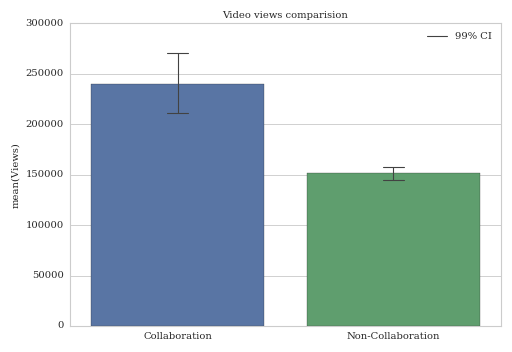

<IPython.core.display.Javascript object>


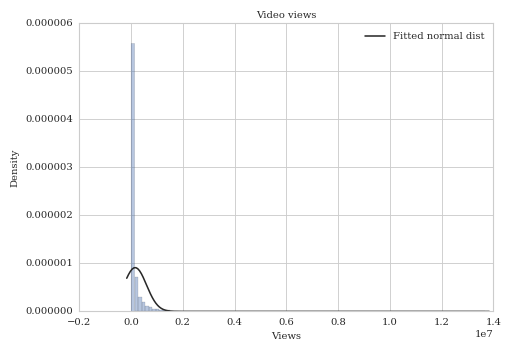

Normal-dist-test: NormaltestResult(statistic=41944.737640979583, pvalue=0.0)

Mann-Whitney-test: MannwhitneyuResult(statistic=37200836.5, pvalue=1.673273414486237e-34)
Wilcoxon rank-sum-test: RanksumsResult(statistic=12.25032462700478, pvalue=1.6732479596795663e-34)


In [149]:
test = df_videos_collabs[df_videos_collabs["6day_viewmax"].notnull()]

# df_channel_history['viewCount_gradient']
fig = plt.figure()
ax = sns.barplot(x="collab_window", y="6day_viewmax", data=test, ci=99,errwidth=1., capsize=.1)
plt.legend(["{}% CI".format(99)])
ax.set_xticklabels(['Collaboration', 'Non-Collaboration'])
ax.set_xlabel('')
ax.set_ylabel('mean(Views)')
plt.title('Video views comparision')
plt.tight_layout()


#fig = plt.figure()
#ax = sns.distplot(test['6day_viewmax'], kde=False)
#ax.set_yscale('log')
#ax.set_xscale('log')

from scipy.stats import norm, normaltest, mannwhitneyu, ranksums

# Distribution fitting
# norm.fit(data) returns a list of two parameters 
# (mean, parameters[0] and std, parameters[1]) via a MLE(Maximum-Likelihood) approach 
# to data, which should be in array form.
(mu, sigma) = stats.norm.fit(test['6day_viewmax'])

fig = plt.figure()
ax = sns.distplot(test['6day_viewmax'], fit=norm, kde=False, bins=100, norm_hist=True)
#plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.legend(["Fitted normal dist"])
ax.set_xlabel('Views')
ax.set_ylabel('Density')
plt.title('Video views')
plt.tight_layout()


print 'Normal-dist-test:', normaltest(test['6day_viewmax'])

collabs_grads = test[test.collab_window == 'Collab']['6day_viewmax']
non_collabs_grads = test[test.collab_window == 'Non_Collab']['6day_viewmax']

print '\nMann-Whitney-test:', mannwhitneyu(x=collabs_grads, y=non_collabs_grads, alternative='two-sided')
print 'Wilcoxon rank-sum-test:', ranksums(x=collabs_grads, y=non_collabs_grads)

In [217]:
# take every channel and get max/mean of collab, non_collab groups for views etc.
# create list with two entrys for every channel, collab, non_collab with mean value of above

df_video_channel_mean = df_videos_collabs.groupby(['channelID', 'collab_window'], as_index=False).mean()
print len(df_video_channel_mean)
#df_videos_collabs.head()
video_channel_group = df_video_channel_mean.groupby('channelID')
print len(video_channel_group)

# calc growth of collab to non_collab per channel, only the two of same channel is comparable directly
df_collab_growth = []

for name, group in video_channel_group:
    if len(group) > 1:
        #print name
        #print group[['collab_window', '6day_viewmax']]
        c_v = group.iloc[0]['12day_viewmax']
        nc_v = group.iloc[1]['12day_viewmax']
        g = 100.0 * c_v / nc_v - 100
        #print g
        df_collab_growth.append((name, g))
    #else:
        #print name, group

df_collab_growth = pa.DataFrame(df_collab_growth)
print len(df_collab_growth)
#print df_collab_growth.head()
#df_collab_growth[1].mean()

1768
1059
709


<IPython.core.display.Javascript object>


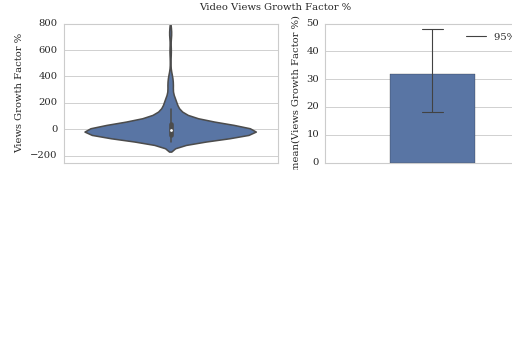

                 1
count   631.000000
mean     31.801130
std     182.102630
min     -97.885285
25%     -42.621524
50%      -5.566582
75%      38.907398
max    2249.390977


In [251]:
# average difference, or growth between collab and noncollab, in%
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.violinplot(data=df_collab_growth, ax=ax1, bw=.2)
sns.barplot(data=df_collab_growth, ci=95,errwidth=1., capsize=.1, ax=ax2)
plt.legend(["{}% CI".format(95)])
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('Views Growth Factor %')
ax2.set_ylabel('mean(Views Growth Factor %)')
fig.suptitle('Video Views Growth Factor %')
ax1.set_xticklabels([''])
ax2.set_xticklabels([''])
fig.tight_layout()
fig.subplots_adjust(top=0.86)
ax1.set_ylim([-250.0, 800.0])


for bar in ax2.patches:
    x = bar.get_x()
    width = bar.get_width()
    centre = x+width/2.
    newwidth = width/2
    bar.set_x(centre-newwidth/2.)
    bar.set_width(newwidth)
    
save_plot('collab_video_12day_growth_factor_box_ci_violin.pdf', fig, 2*s_width, s_height)

print df_collab_growth.describe()